# 사전설정

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np

## 종목 설정

In [6]:
tickers = {
    'KOSPI200': '069500.KS',
    '나스닥100': '133690.KS',
    '국고채10년': '152380.KS',
    '골드': '132030.KS',
    '밸류Plus': '244670.KS'
}

# 데이터 로드

In [7]:
# 팩터 계산을 위해 1년치 이상의 과거 데이터 필요
start_date = '2023-01-01'
end_date = '2024-12-31'
backtest_start_date = '2024-01-01'
initial_capital = 100000000
top_n = 2 # 상위 N개 종목에 투자

In [8]:
try:
    # 데이터 다운로드
    raw_data = yf.download(list(tickers.values()), start=start_date, end=end_date, progress=False, auto_adjust=False)
    
    # Close 가격 추출 (Adj Close가 없으므로 Close 사용)
    data = raw_data['Close'].copy()
    
    # 컬럼명을 티커명으로 변경
    data.columns = tickers.keys()
    
    if data.isnull().values.any():
        print("데이터에 누락된 값이 있어 채워넣습니다.")
        data.fillna(method='ffill', inplace=True)
    
    print("데이터 다운로드 성공!")
    print(f"데이터 형태: {data.shape}")
    print(f"\n최근 5행:\n{data.tail()}")
    
except Exception as e:
    import traceback
    print(f"데이터 다운로드 중 오류 발생: {e}")
    traceback.print_exc()

데이터에 누락된 값이 있어 채워넣습니다.
데이터 다운로드 성공!
데이터 형태: (470, 5)

최근 5행:
            KOSPI200   나스닥100    국고채10년       골드  밸류Plus
Date                                                    
2024-12-23   32400.0  15970.0  138730.0  69450.0  8020.0
2024-12-24   32425.0  15905.0  139330.0  69165.0  8035.0
2024-12-26   32235.0  15965.0  142490.0  69020.0  7960.0
2024-12-27   32145.0  16015.0  141825.0  69000.0  7790.0
2024-12-30   32060.0  15915.0  140880.0  69065.0  7780.0


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4884\3773039937.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


# 백테스트 수행

## 전략 검증 포인트
- ✅ **팩터 1: 모멘텀** - 1, 3, 6, 12개월 수익률 평균
- ✅ **팩터 2: 저변동성** - 연간 변동성의 역수
- ✅ **스코어링**: Z-Score 정규화 후 50:50 가중 평균
- ✅ **자산 선정**: 종합 스코어 상위 2개 종목
- ✅ **자금 배분**: 선정 종목에 균등 배분 (50:50)
- ✅ **리밸런싱**: 매월 마지막 거래일 장 마감 후

In [9]:
# 백테스트 시뮬레이션
backtest_data = data.loc[backtest_start_date:]
rebalance_dates = backtest_data.resample('M').last().index

portfolio_history = pd.Series(index=backtest_data.index, dtype=float)

for i in range(len(rebalance_dates)):
    rebal_date = rebalance_dates[i]
    
    # 팩터 스코어 계산을 위한 1년 데이터
    hist_data = data.loc[:rebal_date].tail(252)
    
    # 모멘텀 스코어 (1,3,6,12개월 평균)
    m1 = (hist_data.iloc[-1] / hist_data.iloc[-22]) - 1 if len(hist_data) >= 22 else 0
    m3 = (hist_data.iloc[-1] / hist_data.iloc[-64]) - 1 if len(hist_data) >= 64 else 0
    m6 = (hist_data.iloc[-1] / hist_data.iloc[-127]) - 1 if len(hist_data) >= 127 else 0
    m12 = (hist_data.iloc[-1] / hist_data.iloc[0]) - 1 if len(hist_data) >= 252 else 0
    momentum_score = (m1 + m3 + m6 + m12) / 4.0

    # 저변동성 스코어 (1년 변동성의 역수)
    volatility = hist_data.pct_change().std() * np.sqrt(252)
    low_vol_score = 1 / volatility

    # Z-Score 정규화 및 종합 스코어 산출
    mom_z = (momentum_score - momentum_score.mean()) / momentum_score.std()
    vol_z = (low_vol_score - low_vol_score.mean()) / low_vol_score.std()
    total_score = mom_z.fillna(0) * 0.5 + vol_z.fillna(0) * 0.5

    # 상위 N개 종목 선정
    selected_assets = total_score.nlargest(top_n).index
    
    print(f"\n[{rebal_date.strftime('%Y-%m-%d')}] 리밸런싱 (장 마감 후)")
    print(f"종합 스코어: {total_score.round(2).to_dict()}")
    print(f"선택 자산: {list(selected_assets)}")

    # 리밸런싱 적용 기간 설정 (다음 영업일부터)
    start_period = rebal_date + pd.Timedelta(days=1)
    
    if i < len(rebalance_dates) - 1:
        end_period = rebalance_dates[i+1]
    else:
        end_period = backtest_data.index[-1]
    
    # 실제 거래일만 필터링
    period_data = backtest_data.loc[start_period:end_period, selected_assets]
    
    if len(period_data) == 0:
        print(f"  ⚠ 적용 기간 데이터 없음")
        continue
    
    print(f"  → 적용 기간: {period_data.index[0].strftime('%Y-%m-%d')} ~ {period_data.index[-1].strftime('%Y-%m-%d')}")
    
    # 동일 가중 투자 (선택된 자산에 균등 배분)
    weights = 1.0 / len(selected_assets)
    
    # 이전 기간의 포트폴리오 가치 사용
    if i == 0:
        temp_value = initial_capital
    else:
        # 가장 최근 포트폴리오 가치 찾기
        available_dates = portfolio_history.dropna().index
        if len(available_dates) > 0:
            last_date = available_dates[-1]
            temp_value = portfolio_history.loc[last_date]
        else:
            temp_value = initial_capital
    
    print(f"  → 리밸런싱 기준 평가액: {temp_value:,.0f}원")
    
    # 자산 수량 계산
    asset_shares = (temp_value * weights) / period_data.iloc[0]
    
    # 일별 포트폴리오 가치 계산
    portfolio_daily_value = (period_data * asset_shares).sum(axis=1)
    
    # 포트폴리오 히스토리에 저장
    portfolio_history.loc[period_data.index] = portfolio_daily_value
    
    print(f"  → 기간 종료 평가액: {portfolio_daily_value.iloc[-1]:,.0f}원")
    print(f"  → 기간 수익률: {(portfolio_daily_value.iloc[-1]/temp_value - 1)*100:+.2f}%")


[2024-01-31] 리밸런싱 (장 마감 후)
종합 스코어: {'KOSPI200': -0.7, '나스닥100': -0.5, '국고채10년': 0.54, '골드': 0.79, '밸류Plus': -0.14}
선택 자산: ['골드', '국고채10년']
  → 적용 기간: 2024-02-01 ~ 2024-02-29
  → 리밸런싱 기준 평가액: 100,000,000원
  → 기간 종료 평가액: 101,541,511원
  → 기간 수익률: +1.54%

[2024-02-29] 리밸런싱 (장 마감 후)
종합 스코어: {'KOSPI200': -0.35, '나스닥100': -0.45, '국고채10년': 0.63, '골드': 0.53, '밸류Plus': -0.35}
선택 자산: ['국고채10년', '골드']
  → 적용 기간: 2024-03-04 ~ 2024-03-29
  → 리밸런싱 기준 평가액: 101,541,511원
  → 기간 종료 평가액: 102,372,322원
  → 기간 수익률: +0.82%

[2024-03-31] 리밸런싱 (장 마감 후)
종합 스코어: {'KOSPI200': -0.23, '나스닥100': -0.02, '국고채10년': 0.57, '골드': 0.44, '밸류Plus': -0.76}
선택 자산: ['국고채10년', '골드']
  → 적용 기간: 2024-04-01 ~ 2024-04-30
  → 리밸런싱 기준 평가액: 102,372,322원
  → 기간 종료 평가액: 100,761,807원
  → 기간 수익률: -1.57%

[2024-04-30] 리밸런싱 (장 마감 후)
종합 스코어: {'KOSPI200': -0.31, '나스닥100': 0.09, '국고채10년': 0.54, '골드': 0.31, '밸류Plus': -0.62}
선택 자산: ['국고채10년', '골드']
  → 적용 기간: 2024-05-02 ~ 2024-05-31
  → 리밸런싱 기준 평가액: 100,761,807원
  → 기간 종료 평가액: 104,572,920원
  → 기간

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4884\1112809250.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = backtest_data.resample('M').last().index


# 성과분석

In [10]:
# 4. 성과 분석
portfolio_df = portfolio_history.dropna().to_frame('Portfolio')
portfolio_df['Daily_Return'] = portfolio_df['Portfolio'].pct_change()

final_value = portfolio_df['Portfolio'].iloc[-1]
cagr = ((final_value / initial_capital) ** (365.0 / len(portfolio_df))) - 1

rolling_max = portfolio_df['Portfolio'].cummax()
daily_drawdown = portfolio_df['Portfolio'] / rolling_max - 1.0
mdd = daily_drawdown.min()
sharpe_ratio = portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() * np.sqrt(252)

print(f"초기 자산: {initial_capital:,.0f} 원")
print(f"최종 자산: {final_value:,.0f} 원")
print(f"CAGR (연율화 수익률): {cagr:.2%}")
print(f"MDD (최대 낙폭): {mdd:.2%}")
print(f"Sharpe Ratio (샤프 지수): {sharpe_ratio:.2f}\n")

초기 자산: 100,000,000 원
최종 자산: 115,635,410 원
CAGR (연율화 수익률): 27.39%
MDD (최대 낙폭): -7.85%
Sharpe Ratio (샤프 지수): 1.83



# 성과 시각화

In [13]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 포트폴리오 가치 추이

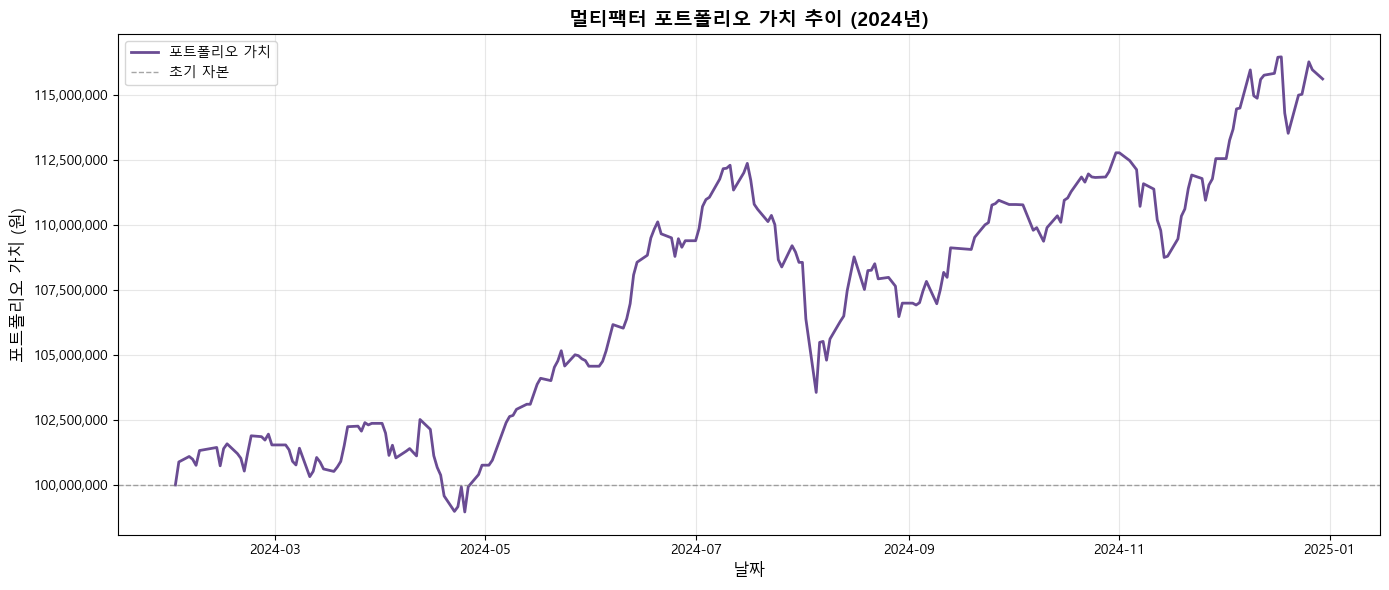

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(portfolio_df.index, portfolio_df['Portfolio'], linewidth=2, color='#6A4C93', label='포트폴리오 가치')
ax.axhline(y=initial_capital, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='초기 자본')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('포트폴리오 가치 (원)', fontsize=12)
ax.set_title('멀티팩터 포트폴리오 가치 추이 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

## 2. 누적 수익률 추이

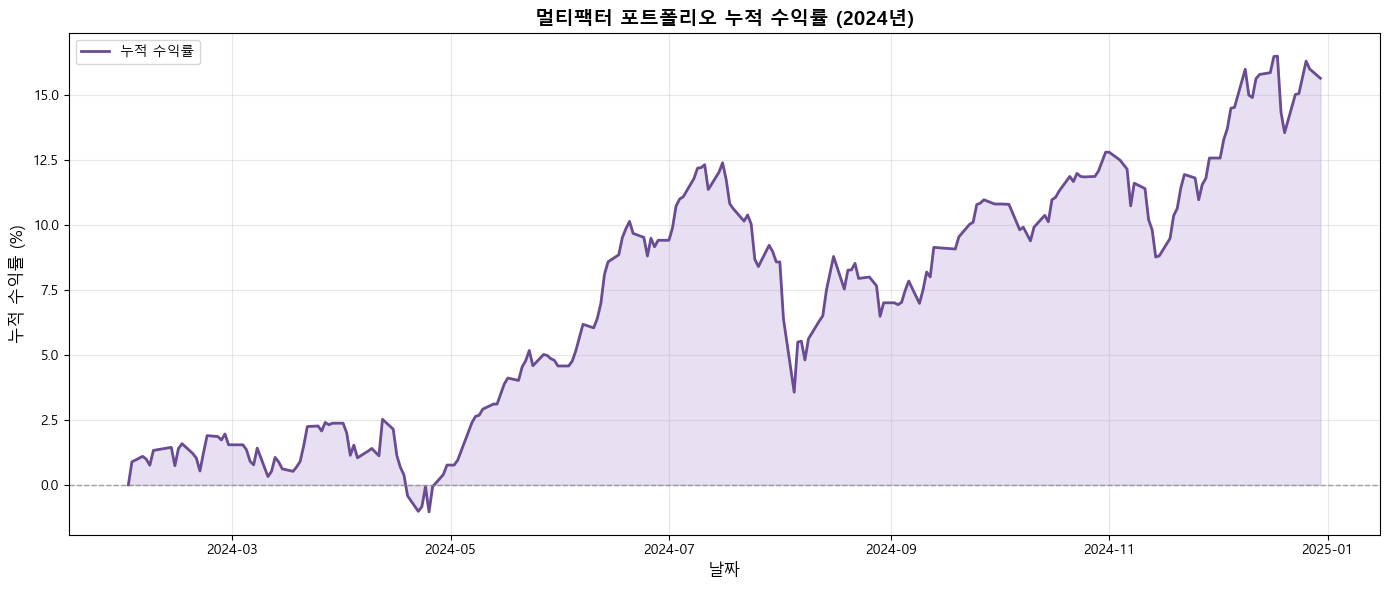

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

cumulative_return = (portfolio_df['Portfolio'] / initial_capital - 1) * 100

ax.plot(portfolio_df.index, cumulative_return, linewidth=2, color='#6A4C93', label='누적 수익률')
ax.fill_between(portfolio_df.index, cumulative_return, 0, alpha=0.2, color='#8B5FBF')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('누적 수익률 (%)', fontsize=12)
ax.set_title('멀티팩터 포트폴리오 누적 수익률 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 낙폭(Drawdown) 분석

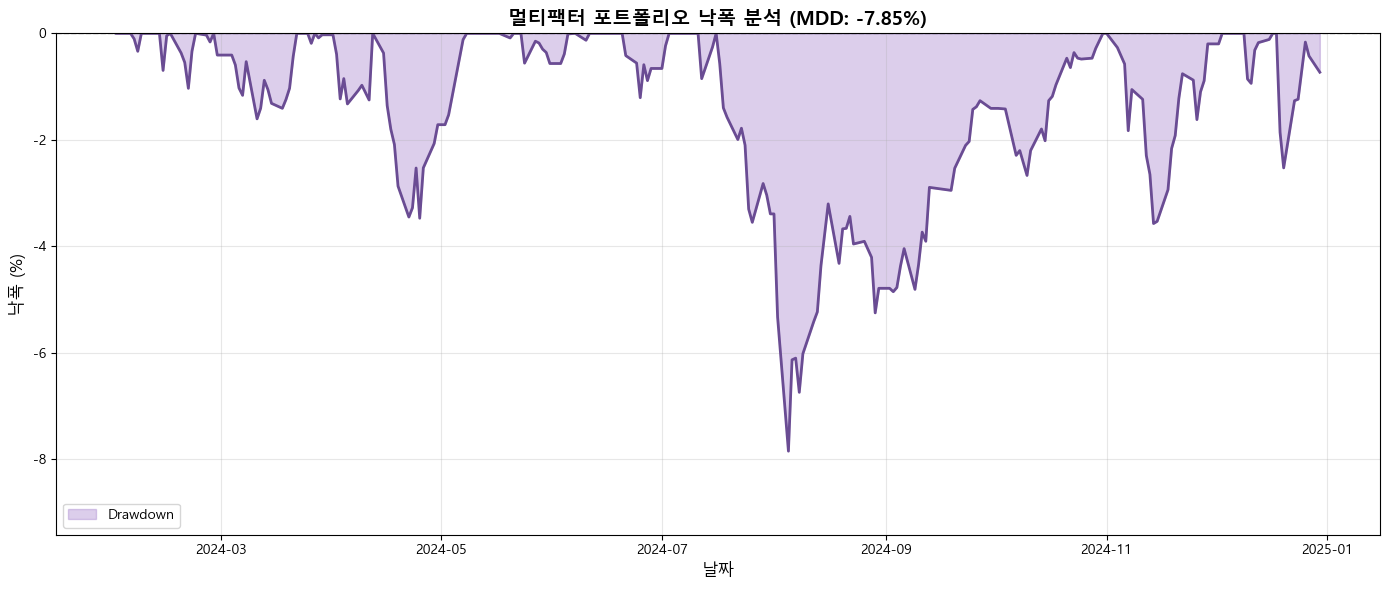

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))

drawdown_pct = daily_drawdown * 100

ax.fill_between(portfolio_df.index, drawdown_pct, 0, alpha=0.3, color='#8B5FBF', label='Drawdown')
ax.plot(portfolio_df.index, drawdown_pct, linewidth=2, color='#6A4C93')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

y_min = min(drawdown_pct.min() * 1.2, -1)
ax.set_ylim(y_min, 0)

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('낙폭 (%)', fontsize=12)
ax.set_title(f'멀티팩터 포트폴리오 낙폭 분석 (MDD: {mdd:.2%})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

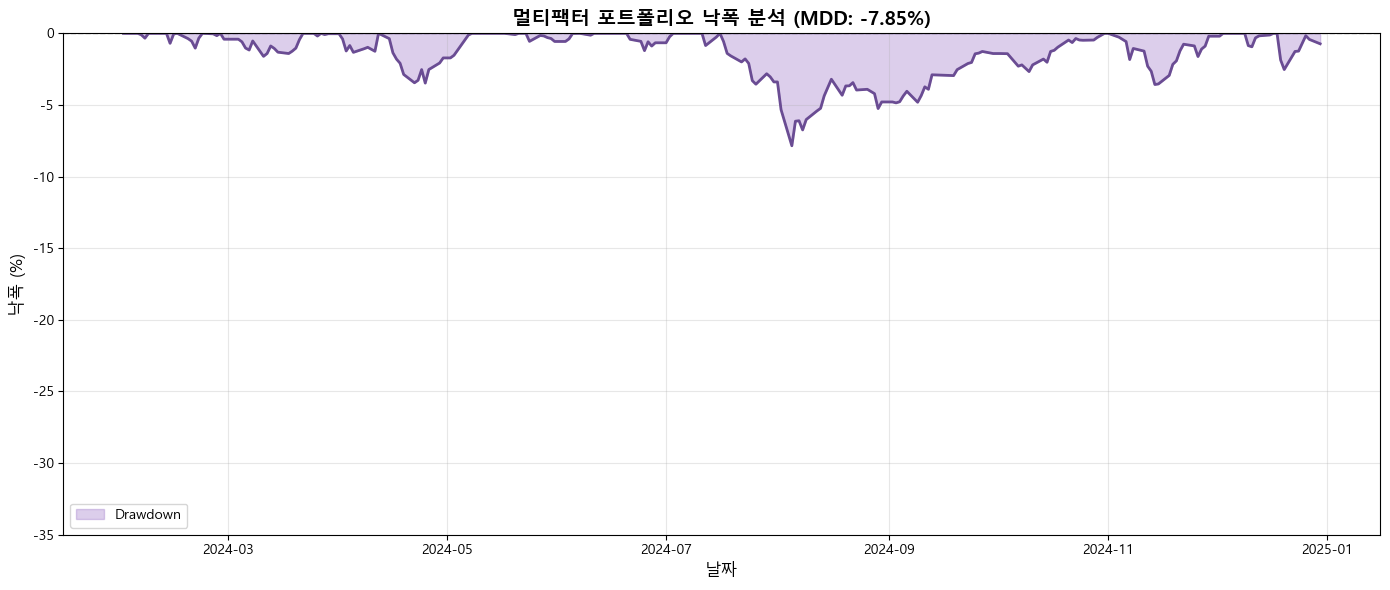

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))

drawdown_pct = daily_drawdown * 100

ax.fill_between(portfolio_df.index, drawdown_pct, 0, alpha=0.3, color='#8B5FBF', label='Drawdown')
ax.plot(portfolio_df.index, drawdown_pct, linewidth=2, color='#6A4C93')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

ax.set_ylim(-35, 0)

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('낙폭 (%)', fontsize=12)
ax.set_title(f'멀티팩터 포트폴리오 낙폭 분석 (MDD: {mdd:.2%})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 일별 수익률 분포

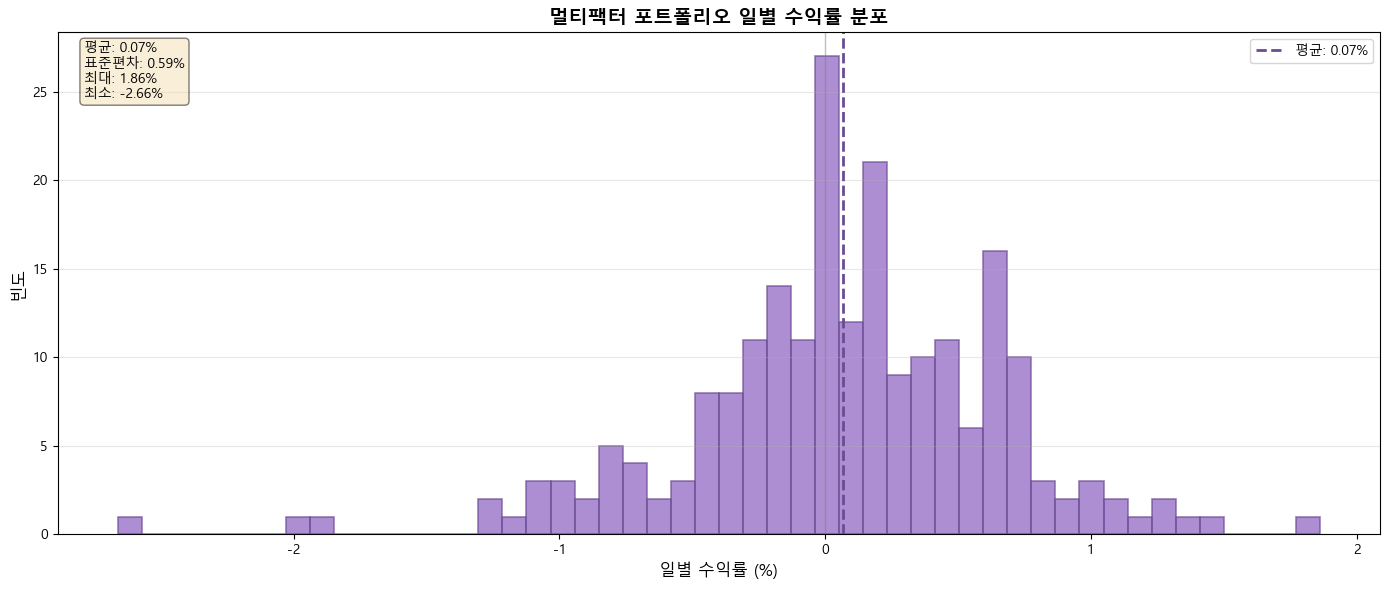

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))

daily_returns_pct = portfolio_df['Daily_Return'].dropna() * 100

ax.hist(daily_returns_pct, bins=50, alpha=0.7, color='#8B5FBF', edgecolor='#6A4C93', linewidth=1.2)
ax.axvline(x=daily_returns_pct.mean(), color='#6A4C93', linestyle='--', linewidth=2, label=f'평균: {daily_returns_pct.mean():.2f}%')
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('일별 수익률 (%)', fontsize=12)
ax.set_ylabel('빈도', fontsize=12)
ax.set_title('멀티팩터 포트폴리오 일별 수익률 분포', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 통계량 표시
textstr = f'평균: {daily_returns_pct.mean():.2f}%\n표준편차: {daily_returns_pct.std():.2f}%\n최대: {daily_returns_pct.max():.2f}%\n최소: {daily_returns_pct.min():.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## 5. 월별 수익률

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4884\2396898638.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100


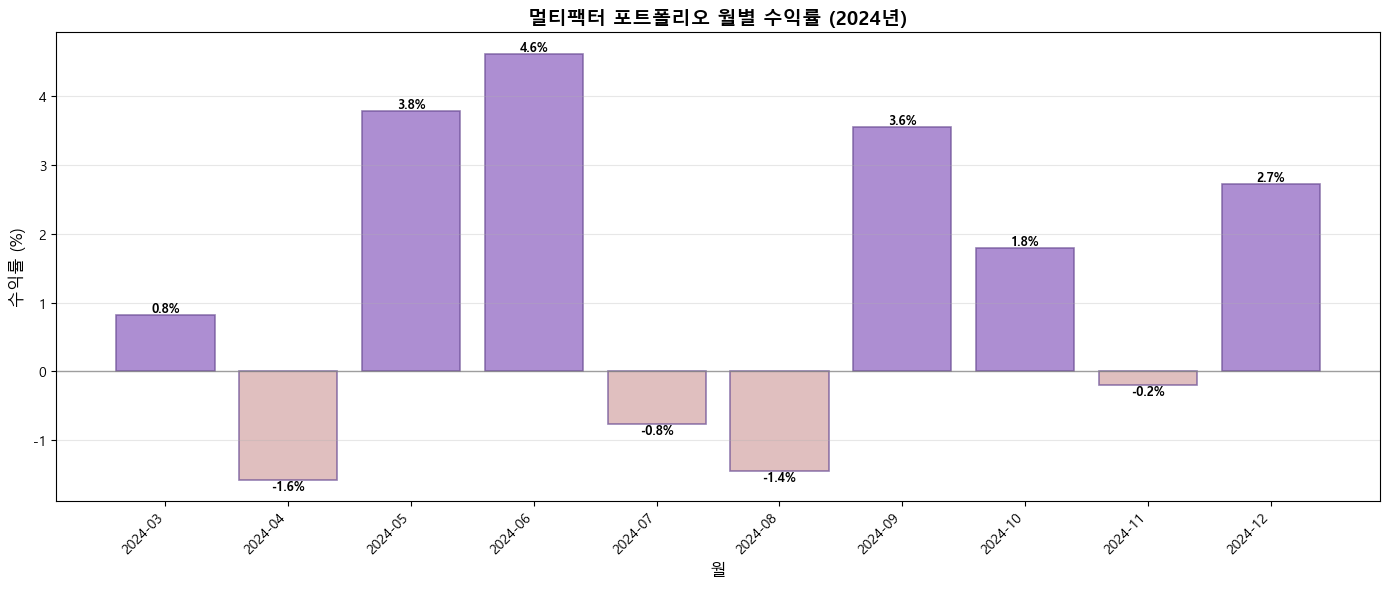

In [18]:
monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#8B5FBF' if x >= 0 else '#D4A5A5' for x in monthly_returns]
bars = ax.bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7, edgecolor='#6A4C93', linewidth=1.2)

ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.7)
ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('수익률 (%)', fontsize=12)
ax.set_title('멀티팩터 포트폴리오 월별 수익률 (2024년)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(monthly_returns)))
ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_returns.index], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for i, (bar, value) in enumerate(zip(bars, monthly_returns)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()